In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import json
import time
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, DataStructs
from sklearn.decomposition import PCA
from utils import *
from preprocessing import load_data
from RandomFeats import define_rand_feats
from DirectionalMLP import mlp_main, generate

In [2]:
### CONFIG
task = 'potency'
K = 32 # Num pca components
percentile = 25 # Upper pth percentile for subsets
solver = False # Solver for LogisticRegression (True - liblin, slower but better)
N = 1024 # Num betas to fit (Typically 512 or 1280)
M = 25_000 # Num betas to generate for inference (Typically 25k-100k)

In [3]:
data = load_data(task, K)

In [4]:
np.random.seed(74)
X, Y = data['train']
D = K * 5
model = define_rand_feats(X, D)

In [5]:
print(X.shape)
print(Y.shape)

(12699, 32)
(12699,)


In [6]:
dirs = np.random.randn(N, K)
dirs = dirs / np.linalg.norm(dirs, axis=1, keepdims=True)

In [7]:
betas = []
accs = []
i = 0
print(f"Starting {len(dirs)} models")
start_time = time.time()
for dir in dirs:
    if i % 25 == 0 and i:
        curr_time = time.time()
        elapsed_time = (curr_time - start_time)/60 # min
        print(f"Step {i} - Time Elapsed: {elapsed_time:.2f} min - est {elapsed_time/i*len(dirs) - elapsed_time:.2f} min remaining")
        print(f"\t\tCurrent Beta Accuracy: {np.mean(np.array(accs))}")

    X_sub, X_ids = project_and_filter(X, dir, percentile)
    Y_sub = Y[X_ids]
    beta, acc = log_coeffs(model(X_sub), Y_sub, solver)

    betas.append(beta)
    accs.append(acc)
    i += 1
    if i == len(dirs) - 1: print(f"Done")

betas = np.array(betas)
accs = np.array(accs)

Starting 64 models
Step 25 - Time Elapsed: 0.36 min - est 0.56 min remaining
		Current Beta Accuracy: 0.8836565064757335
Step 50 - Time Elapsed: 0.70 min - est 0.19 min remaining
		Current Beta Accuracy: 0.8844363596742022
Done


In [8]:
betas = tf.squeeze(betas)
dirs = tf.constant(dirs)
print("Modeling Training complete with Subset Accuracies: ", np.mean(accs))

Modeling Training complete with Subset Accuracies:  0.885274291950745


Accuracy:  0.5929078014184397
Precision:  0.6166328600405679
Recall:  0.6617326948193296


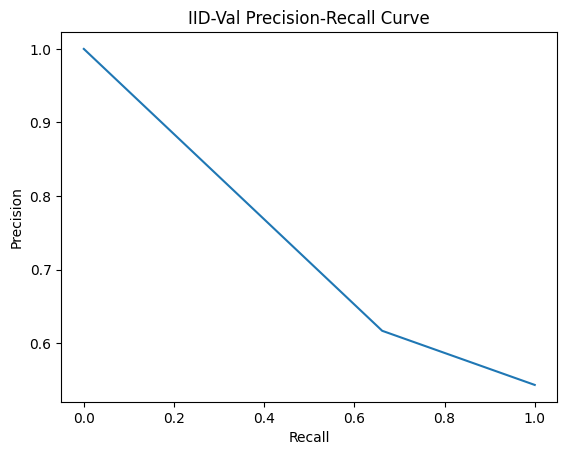

In [9]:
# Eval on iid val data
X_iid_val, Y_iid_val = data['iid_val']
X_iid_val_rand = model(X_iid_val)
evaluate(X_iid_val_rand, Y_iid_val, betas)

In [10]:
# Beta Model
mlp_ret = mlp_main(np.array(dirs), np.array(betas), X, model(X), percentile)
print(f"MLP Metrics:\n\tTest Loss - {mlp_ret['test_loss']}\n\Agreement: Overall - {mlp_ret['overall_agreement']}, Subset - {mlp_ret['subset_agreement']}")

c:\ProgramData\anaconda3\envs\EveryDirHoldsSoln\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1367
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1327
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1292
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1267
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1237
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1204 
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1168 
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1142
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1092
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1067
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1171
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
MLP Metrics:
	Test Loss - 0.11707095056772232
\Agreement: Overall - 0.6159479547147867, Subset - 0.6515478291913763


In [13]:
# Draw new betas
gen_dirs, gen_betas = generate(mlp_ret['mlp'], M, K)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Accuracy:  0.5128673671387239
Precision:  0.458462492250465
Recall:  0.5046059365404298


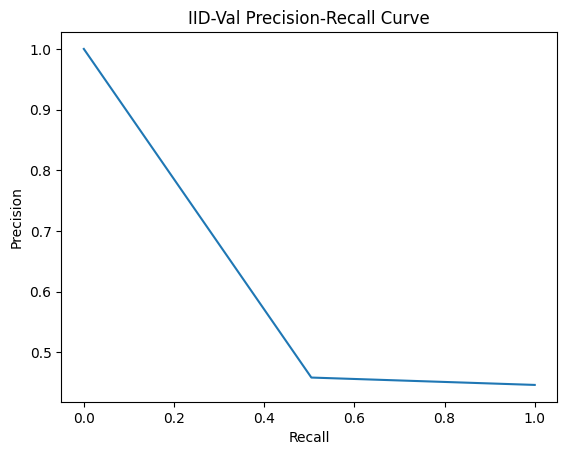

In [14]:
# Eval on ood val data
X_ood_val, Y_ood_val = data['ood_val']
X_ood_val_rand = model(X_ood_val)
evaluate(X_ood_val_rand, Y_ood_val, gen_betas)

Accuracy:  0.5157423454650492
Precision:  0.6234656009135027
Recall:  0.5177809388335705


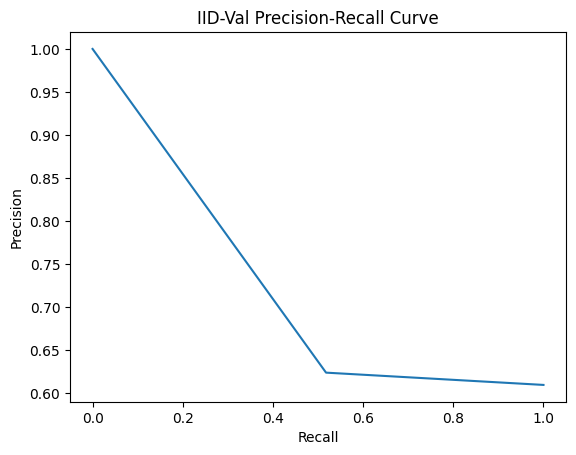

In [15]:
# Eval on ood test data
X_ood_test, Y_ood_test = data['ood_test']
X_ood_test_rand = model(X_ood_test)
evaluate(X_ood_test_rand, Y_ood_test, gen_betas)